# Modelos individuais

* Modelos onde cada indivíduo é tratado como uma variável, com características próprias.

* Podem ser mapeamentos (discretos no tempo) ou sistemas de equações diferenciais (contínuos no tempo). 

* Podem ser determinísticos ou estocásticos.

* Vamos ver, concretamente, um modelo individual discreto estocástico.

In [27]:
using LinearAlgebra
using Random
using StatsBase
using Plots

## Cenário

* Criamos um "cenário", com um determinado número `N` de indivíduos e vetores de comprimento `N` com os atributos de cada indivíduo.

* Há várias formas de se fazer isso, dependendo do nível de detalhamento que queiramos fazer.

* Podemos determinar a idade de cada indivíduo, o grau de susceptibilidade e de infectividade de cada indivíduo, a posição espacial onde o indivíduo se encontra em cada instante, etc..

* No exemplo a seguir, vamos considerar, apenas, graus de susceptibilidade e de infectividade.

* Além disso, precisamos de um vetor indicando o estágio, ou estado, da doença em cada indivíduo.

### Atributos

* Vamos definir, então, um vetor `estado`, onde cada elemento do vetor representa o estágio epidemiológico de cada indivíduo. Vamos considerar, a título de exemplo, três possíveis estados: **suscetível,** **infectado** e **recuperado**. Vamos representá-los, no vetor, pelos inteiros `0`, `1` e `2`, respectivamente.

* O grau de susceptibilidade de cada indivíduo é representado por um real positivo. Isso será representado por um vetor `susceptibilidade` de números em ponto flutuante. Há estudos indicando que esse grau segue uma distribuição beta, na população. Para simplificar, vamos apenas usar uma distribuição uniforme entre dois números positivos.

* Idem para o vetor `infectividade`.

* Da mesma forma, consideramos um vetor `recuperacao`, indicando a taxa de recuperação de cada indivíduo, no caso dele vir a ser infectados. Vamos considerar essa atributo correlacionado ao atributo de susceptibilidade.

### Parâmetros epidemiológicos globais

* Em relação aos outros parâmetros epidemiológicos, consideramos os seguintes.

* Uma taxa $\tau$ de contágios por contato próximo.

* Uma taxa média $\kappa$ de número de contatos próximos por indivíduo.

In [47]:
# Cenário

N = 10_000 # população
estado = zeros(Int,N)
infectividade = 0.5 .+ rand(N)
susceptibilidade = 0.5 .+ rand(N)
recuperacao = 1 ./ (1 .+ 9 * rand(N)) # distribuição uniforme entre 1 e 10 dias de recuperação
recuperaco = 1 ./ (1 .+ 6 * rand(N) .* susceptibilidade)

10000-element Vector{Float64}:
 0.17724319599282753
 0.16722035076129818
 0.44506278200595045
 0.23019409705858482
 0.6588832634314359
 0.19784671685593308
 0.469258083377501
 0.25173359937633744
 0.5993710367186366
 0.15029916691823766
 ⋮
 0.13450920520721193
 0.173359735788814
 0.1801842184349306
 0.3691273836433749
 0.15990077541374503
 0.19885581231059865
 0.7369164673460924
 0.37089403839288526
 0.1763404244703938

In [51]:
κ = 0.02 # taxa de contágio por contato próximo
τ = 20 # número médio de contatos por indivíduo
nothing

## Dinâmica da epidemia

* Este é um modelo SIR individual.

* Cada indivíduo suscetível pode se tornar infectado através do contato com indivíduos infectados.

* E cada indivíduo infectado se recupera de acordo com a sua taxa de recuperação.

* Este é um modelo discreto no tempo, com cada iteração correspondendo a um dia de evolução.

* Também é um modelo estocástico. A cada passo de tempo, cada indivíduo suscetível *pode* se tornar infectado dependendo de um número sorteado aleatoriamente ser maior ou não do que a *força de infecção* agindo no indivíduo, ponderada pelo grau de susceptibilidade do indivíduo.

* E cada indivíduo infectado *pode* se recuperar dependendo de um número sorteado aleatoriamente ser menor ou não do que a taxa de recuperação do indivíduo.

### Força de infecção

* A força de infecção de um indivíduo é calculada de acordo com o grau de infectividade dos indivíduos infectados que tenham tido contato com o indivíduo em questão.

* Os contatos entre os indivíduos são definidos aleatoriamente a cada passo. Há várias estruturas que podemos usar (aglomerados residenciais, aglomerados escolares, aglomerados em postos de trabalho, redes de contato entre amigos, encontros aleatórios entre a população em geral - e.g. em meios de transporte, lojas de comércio, parques, shows, etc.).

* Para simplificar, no entanto, vamos considerar, apenas, aglomerados arbitrários sorteados a cada passo de tempo.

## Quantidades de interesse

* Para simplificar, não vamos guardar o histórico de cada indivíduo. O vetor com o estado epidemiológico da população será atualizado a cada passo de tempo.

* Vamos guardar o histórico, apenas, do total de indivíduos em cada estágio epidemiológico.

## Simulação

* Abaixo implementamos o modelo descrito acima.

In [54]:
# Evolução
num_dias = 180

# inicialização
ninf0 = 2
inf0 = sample(1:N, ninf0)
estado = zeros(Int, N)
estado[inf0] .= 1

# compartimentos
suscetiveis = zeros(Int, num_dias)
infectados = zeros(Int, num_dias)
recuperados = zeros(Int, num_dias)
suscetiveis[1] = count(estado .== 0)
infectados[1] = count(estado .== 1)
recuperados[1] = count(estado .== 2)

# força de infecção
λ = zeros(N)

# contatos
contatos = collect(1:N)

# evolução
for n in 2:num_dias
    λ .= 0.0
    shuffle!(contatos)
    i = 1
    while i ≤ N
        ip = min(i + rand(div(τ, 2):2τ), N)
        if any(==(1), estado[contatos[i:ip]])
            λ[contatos[i:ip]] .= κ * sum(infectividade[contatos[j]] for j in i:ip if estado[contatos[j]] == 1)
        end
        i = ip + 1
    end
    for i in 1:N
        if estado[i] == 0 && rand() > exp(-λ[i])
            estado[i] = 1
        elseif estado[i] == 1 && rand() < recuperacao[i]
            estado[i] = 2
        end        
    end
    suscetiveis[n] = count(estado .== 0)
    infectados[n] = count(estado .== 1)
    recuperados[n] = count(estado .== 2)
end




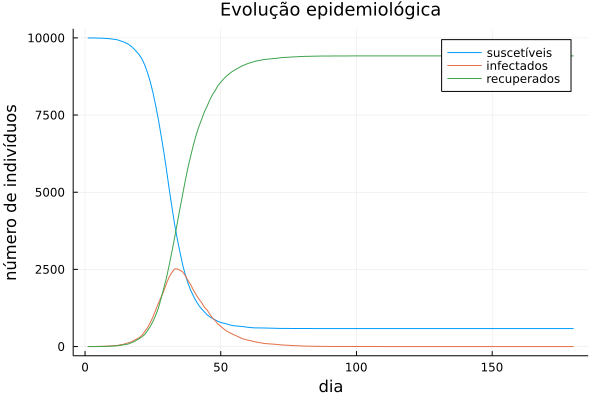

In [55]:
plot(title = "Evolução epidemiológica", titlefont = 12, xaxis = "dia", yaxis = "número de indivíduos")
plot!(suscetiveis, label = "suscetíveis")
plot!(infectados, label = "infectados")
plot!(recuperados, label = "recuperados")



## Referências

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)